# **Time correlators of electric and magnetic Glasma fields, averaged over transverse plane, at various proper times**

Fields correlators of the Glasma $\langle F(\tau)F(\tau+\delta\tau)\rangle$, as a function of proper time difference $\delta\tau$, evaluated starting from a time $\tau$, averaged over the transverse simulation plane where the fields reside. Here $F$ stands for electric $E$ or magnetic $B$ fields.

Import all the necessary modules and packages.

In [3]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.fields_correlators import FieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm

In [4]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 8     # Time step
n_events = 10        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 0.4    # Simulation time [GeV/fm]

Simulation routine for a single event, where all the parameters are stored in a dictionary.

In [5]:
# Define hbar*c [GeV*fm]
hbarc = 0.197326 

def simulate(tau):    
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int((tau_max + tau) / a) * DTS
    mint = int(tau / a) * DTS

    s = core.Simulation(N, DT, G)
    va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    initial.init(s, va, vb)

    output = {}

    fields = FieldsCorrelators(s)

    if use_cuda:
        s.copy_to_device()

    delta_tau = np.zeros(maxt-mint)
    elcorr, magcorr = np.zeros((maxt-mint, 3)), np.zeros((maxt-mint, 3))

    for t in range(maxt+1):
        core.evolve_leapfrog(s)

        if t==mint:  
            E, B = fields.compute_elfield(), fields.compute_magfield()
        elif t>mint:
            EE, BB = fields.compute_elcorr(E), fields.compute_magcorr(B)
            # Fields correlator units [GeV^4]
            units = E0 ** 4
            EE *= units
            BB *= units
            elcorr[t-mint-1], magcorr[t-mint-1] = EE, BB
            delta_tau[t-mint-1] = (t-mint-1) / DTS * a

    output['tau'], output['elcorr'], output['magcorr'] = delta_tau, elcorr, magcorr
        
    return output

Running the simulation for multiple events and various values of formation times.

In [ ]:
elcorr, magcorr, delta_tau = {}, {}, {}

for tau in taus:
    elcorr_tau, magcorr_tau = [], []
    # print("Initial time = {:1.2f} [GeV/fm]".format(tau))
    
    with tqdm(total=n_events) as pbar:
        # pbar.reset()
        for nev in range(0, n_events):
            output = simulate(tau)

            elcorr_tau.append(output['elcorr'])
            magcorr_tau.append(output['magcorr'])

            if nev==0:
                delta_tau[str(tau)] = output['tau']

            # pbar.set_description('Event {} / {}'.format(nev+1, n_events))
            pbar.update(1)
    # pbar.refresh()
    # pbar.reset()

    elcorr[str(tau)], magcorr[str(tau)] = np.mean(elcorr_tau, axis = 0), np.mean(magcorr_tau, axis = 0)
    
results = {}
results['taus'] = taus
results['tau'], results['elcorr'], results['magcorr'] = delta_tau, elcorr, magcorr
results['Qs'], results['hbarc'] = Qs, hbarc
fname = "time_corr_glasma.pickle"
pickle.dump(results, open(fname, "wb"))

## Read data from files using Julia

In [1]:
using Pickle

res = Pickle.npyload("time_corr_glasma.pickle")
tau, elcorr, magcorr = res["tau"], res["elcorr"], res["magcorr"]
Qs, hbarc = res["Qs"], res["hbarc"]
taus = res["taus"]

6-element Vector{Any}:
 0.01
 0.02
 0.05
 0.1
 0.3
 0.5

## Plot results using Makie from Julia

In [2]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

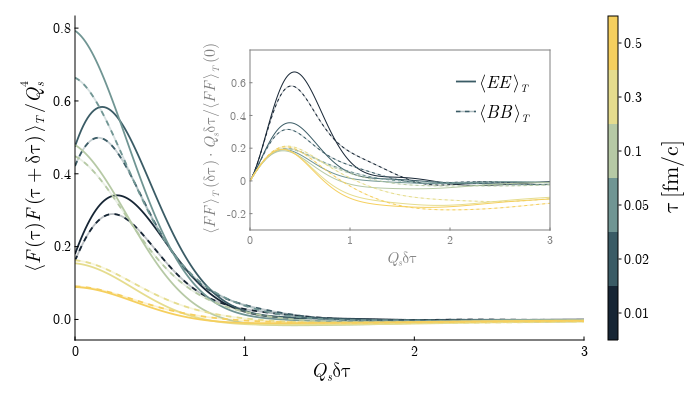

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000b5a0ce0, 3500.0, 2000.0)


In [11]:
using CairoMakie
using ColorSchemes

colormap = cgrad(:starrynight, 6, categorical = true)
colors = [colormap[1], colormap[2], colormap[3], colormap[4], colormap[5], colormap[6]]

fig = Figure(resolution = (700, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s \delta\tau", ylabel=L"\langle F\,(\tau)F\,(\tau+\delta\tau)\,\rangle_T\,/Q_s^4",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false) 

for (i, itau) in enumerate(taus)
        elcorr_tau, magcorr_tau = elcorr[string(itau)]/Qs^4, magcorr[string(itau)]/Qs^4
        τ = tau[string(itau)]*Qs/hbarc

        elcorr_tau_T = elcorr_tau[:, 1] + elcorr_tau[:, 2]
        string_as_varname("line_el_"*string(i), lines!(ax, τ, elcorr_tau_T, linewidth = 1.8, color=colors[i]))
        lines!(ax, τ, magcorr_tau[:, 1] + magcorr_tau[:, 2], linewidth = 1.8, color=(colors[i], 0.3))
        lines!(ax, τ, magcorr_tau[:, 1] + magcorr_tau[:, 2], linewidth = 1.8, color=colors[i], linestyle="-")
end

xlims!(ax, 0, 3)
# ax.xticks = (1*(0:4), ["0", "1", "2", "3", "4"])
# ylims!(ax, -0.005, 0.2)
# ax.yticks = ([0, 0.1, 0.2], ["0", "0.1", "0.2"])

cbar = Colorbar(fig[1, 2], limits = (0, 6), colormap =  colormap = cgrad(:starrynight, 6, categorical = true), size = 25, labelsize = 22, width = 10, flipaxis = true,
ticksize=3, tickalign = 0, ticklabelsize = 14, height = Relative(1), label=L"\tau\,\mathrm{[fm/c]}")
cbar.ticks = ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],  ["0.01", "0.02", "0.05", "0.1", "0.3", "0.5"])

ax_inset = Axis(fig, bbox = BBox(250, 550, 170, 350), 
        xlabel=L"Q_s \delta\tau", ylabel=L"\langle FF\,\rangle_T\,(\delta\tau)\cdot Q_s\delta\tau/\langle FF\,\rangle_T\,(0)",
        xlabelsize = 16, ylabelsize= 16, xticklabelsize=12, yticklabelsize=12,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -2, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

for (i, itau) in enumerate(taus)
        elcorr_tau, magcorr_tau = elcorr[string(itau)], magcorr[string(itau)]
        τ = tau[string(itau)]*Qs/hbarc

        lines!(ax_inset, τ, τ.*(elcorr_tau[:, 1] + elcorr_tau[:, 2])./(elcorr_tau[1, 1] + elcorr_tau[1, 2]), linewidth = 1, color=colors[i])
        lines!(ax_inset, τ, τ.*(magcorr_tau[:, 1] + magcorr_tau[:, 2])./(magcorr_tau[1, 1] + magcorr_tau[1, 2]), linewidth = 1, color=(colors[i], 0.3))
        lines!(ax_inset, τ, τ.*(magcorr_tau[:, 1] + magcorr_tau[:, 2])./(magcorr_tau[1, 1] + magcorr_tau[1, 2]), linewidth = 1, color=colors[i], linestyle="-")
end

xlims!(ax_inset, 0, 3)
# ax_inset.xticks = (1*(0:4), ["0", "1", "2", "3", "4"])
ylims!(ax_inset, -0.3, 0.8)
ax_inset.yticks = ([-0.2, 0, 0.2, 0.4, 0.6], ["-0.2", "0", "0.2", "0.4", "0.6"])

mag = [LineElement(color = colors[2], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[2], 0.4), linewidth = 1.5)]

axislegend(ax_inset, [line_el_2, mag], [L"\langle EE\,\rangle_T", L"\langle BB\,\rangle_T"],  labelsize=18, 
    position = :rt, bgcolor = (:white, 0.7), framecolor = (:white, 0))

display(fig)

save("makie_time_corr_FF_T.png", fig, px_per_unit = 5.0) 

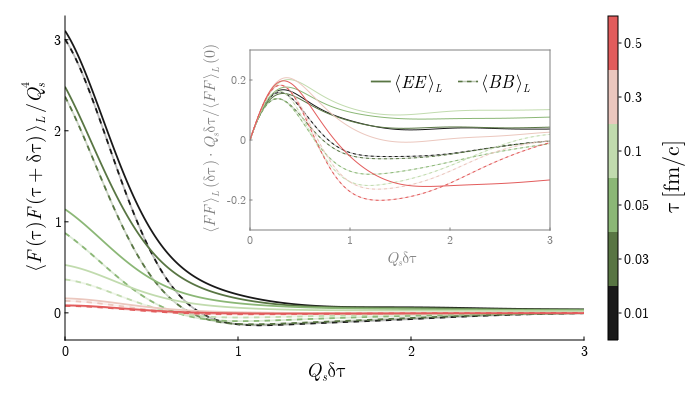

In [16]:
using CairoMakie
using ColorSchemes

colormap = cgrad(:watermelon, 6, categorical = true)
colors = [colormap[1], colormap[2], colormap[3], colormap[4], colormap[5], colormap[6]]

fig = Figure(resolution = (700, 400), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s \delta\tau", ylabel=L"\langle F\,(\tau)F\,(\tau+\delta\tau)\,\rangle_L\,/Q_s^4",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false) 

for (i, itau) in enumerate(taus)
        elcorr_tau, magcorr_tau = elcorr[string(itau)]/Qs^4, magcorr[string(itau)]/Qs^4
        τ = tau[string(itau)]*Qs/hbarc

        string_as_varname("line_el_"*string(i), lines!(ax, τ, elcorr_tau[:, 3], linewidth = 1.8, color=colors[i]))
        lines!(ax, τ, magcorr_tau[:, 3], linewidth = 1.8, color=(colors[i], 0.3))
        lines!(ax, τ, magcorr_tau[:, 3], linewidth = 1.8, color=colors[i], linestyle="-")
end

xlims!(ax, 0, 3)
# ax.xticks = (1*(0:4), ["0", "1", "2", "3", "4"])
# ylims!(ax, -0.02, 0.22)
# ax.yticks = ([0, 0.2, 0.4, 0.6, 0.8], ["0", "0.2", "0.4", "0.6", "0.8"])

cbar = Colorbar(fig[1, 2], limits = (0, 6), colormap =  colormap = cgrad(:watermelon, 6, categorical = true), size = 25, labelsize = 22, width = 10, flipaxis = true,
ticksize=3, tickalign = 0, ticklabelsize = 14, height = Relative(1), label=L"\tau\,\mathrm{[fm/c]}")
cbar.ticks = ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5],  ["0.01", "0.03", "0.05", "0.1", "0.3", "0.5"])

ax_inset = Axis(fig, bbox = BBox(250, 550, 170, 350), 
        xlabel=L"Q_s \delta\tau", ylabel=L"\langle FF\,\rangle_L\,(\delta\tau)\cdot Q_s\delta\tau/\langle FF\,\rangle_L\,(0)",
        xlabelsize = 16, ylabelsize= 16, xticklabelsize=12, yticklabelsize=12,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -2, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

for (i, itau) in enumerate(taus)
        elcorr_tau, magcorr_tau = elcorr[string(itau)], magcorr[string(itau)]
        τ = tau[string(itau)]*Qs/hbarc

        lines!(ax_inset, τ, τ.*elcorr_tau[:, 3]./elcorr_tau[1, 3], linewidth = 1, color=colors[i])
        lines!(ax_inset, τ, τ.*magcorr_tau[:, 3]./magcorr_tau[1, 3], linewidth = 1, color=(colors[i], 0.3))
        lines!(ax_inset, τ, τ.*magcorr_tau[:, 3]./magcorr_tau[1, 3], linewidth = 1, color=colors[i], linestyle="-")
end

xlims!(ax_inset, 0, 3)
# ax_inset.xticks = (1*(0:4), ["0", "1", "2", "3", "4"])
ylims!(ax_inset, -0.3, 0.3)
ax_inset.yticks = ([-0.2, 0, 0.2, 0.4], ["-0.2", "0", "0.2", "0.4"])

mag = [LineElement(color = colors[2], linestyle = "-", linewidth = 1.5), LineElement(color = (colors[2], 0.4), linewidth = 1.5)]

axislegend(ax_inset, [line_el_2, mag], [L"\langle EE\,\rangle_L", L"\langle BB\,\rangle_L"],  labelsize=18, 
    position = :rt, bgcolor = (:white, 0.7), framecolor = (:white, 0), orientation=:horizontal)

display(fig)

# save("makie_time_corr_FF_L.png", fig, px_per_unit = 5.0) 

***
### Late time behaviour of correlators

In [6]:
os.environ["GAUGE_GROUP"] = "su2"

taus = [0.01, 0.05, 0.5, 1, 1.5]
tau_max = 1

elcorr, magcorr, delta_tau = {}, {}, {}

for tau in taus:
    elcorr_tau, magcorr_tau = [], []
    # print("Initial time = {:1.2f} [GeV/fm]".format(tau))
    
    with tqdm(total=n_events) as pbar:
        # pbar.reset()
        for nev in range(0, n_events):
            output = simulate(tau)

            elcorr_tau.append(output['elcorr'])
            # magcorr_tau.append(output['magcorr'])

            if nev==0:
                delta_tau[str(tau)] = output['tau']

            # pbar.set_description('Event {} / {}'.format(nev+1, n_events))
            pbar.update(1)
    # pbar.refresh()
    # pbar.reset()

    elcorr[str(tau)], magcorr[str(tau)] = np.mean(elcorr_tau, axis = 0), np.mean(magcorr_tau, axis = 0)
    
results = {}
results['taus'] = taus
# results['tau'], results['elcorr'], results['magcorr'] = delta_tau, elcorr, magcorr
results['tau'], results['elcorr'] = delta_tau, elcorr
results['Qs'], results['hbarc'] = Qs, hbarc
fname = "late_time_corr_glasma.pickle"
pickle.dump(results, open(fname, "wb"))

 20%|██        | 2/10 [18:59<1:15:48, 568.51s/it]